**[DATA]** 
 
**DATA COLLECTION:**<br>
***Where did the data come from?*** : DeepMind Q&A Dataset (https://cs.nyu.edu/~kcho/DMQA/)<br>

**DATA MANAGEMENT:**<br>
***How did you clean and pre-process the data?***<br>
Text data is preprocessed involved following steps:
- Removing punctuations
- Removing stop words (words which do not add meaning at word level analysis)
- Lemmatization (converts different forms of a single word into one form)

***What recoding of the variables was done after the data was collected?***<br>
- The data essential contained 2 parts, story(text of a news article) and it's highlights.
- After loading the data, a pandas dataframe is created with 2 columns for story and highlights.
- For further analysis, all the story rows are preprocessed using the steps mentioned above and a column of word count of each story is added to the dataframe along with the cleaned stories.

***Was any of the data manipulated manually after it was collected?***<br>
- Data was preprocessed using pre-existing libraries and few manual preprocessing which we thought are necessary like removing text inside brackets.

**ANALYSIS:**<br>
- At the this stage of the project, we are using story highlights to compare our generated summaries.
- We are particularly focusing on word-level analysis.
- Implemented TF-IDF to look for unique words.
- A subset of 100 stories was taken for quick analysis.
- We used cosine similarity to check how similar the generated text is with highlights. Pretty descent score of about 80%(rough average) is observed on word-level summaries. For future work, we would like to improve this my implementing context based sentence ranking to rank high for relevant sentences in the story.

**ARGUMENT:**
- Highlights are a good low level summary for a news story but not a concrete summary. Through this project, we would like to implement a summary generation system which can provide optimum information in few sentence.

**[Design]**<br>

**STAKEHOLDER ANALYSIS:**<br>
- News articles have already been digitilized. This project can benifit 2 types of users, one who wants to consume a particle news story as quickly as possible and one who follows news through digital medium but also worries about staring at the screen for long time.
- Users with resources and ability to use internet to browse through news stories are benefitted through this applicaiton.

**CONTEXT:**<br>
- This project could be a sub-part for a digital news paper. Users will scroll through the User Interface of summaries of digital news paper stories. User can choose to continue reading by clicking on the article if the user wants to know more about the story after reading the summary.
- At this point we don't see any trust or privacy issues with this application because ulimately it the user who decides whether to continue reading the full story based on the summary provided.

**VISUALIZATION:**<br>

**ETHICS:**<br>
- One of the purposes of this project could be to save user's time. By looking at the summary, user can get a brief idea on the topic.
- Though modern NLP algorithms are performing better in understanding the context of a given text, they are far from understanding human intentions beind indirect speeches. This could result in inappropriate summary.
- For such reasons, it is advaisable to take the computer generated summaries with a grain of salt. The intention behind generating these summaries is to get a shorter form of original stories. At current level of the project, the sentences in the summary are selected from the original text.

[Data link]('https://cs.nyu.edu/~kcho/DMQA/')

Structure of CNN story:

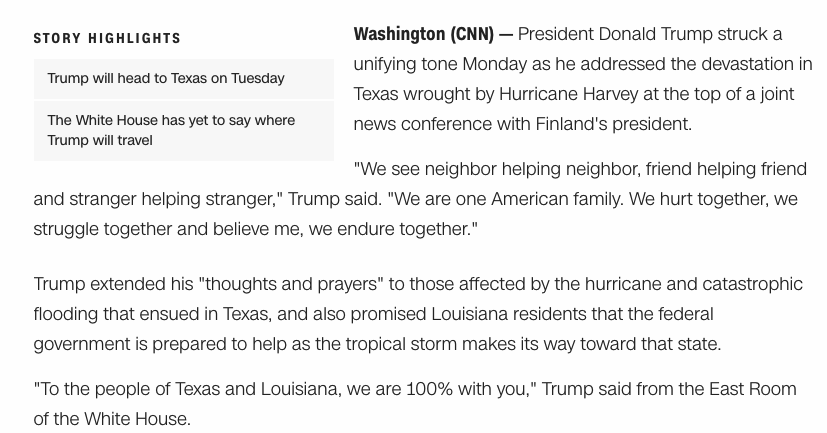

Data set contains both the story and story highlight

### Loading data

In [1]:
from os import listdir
 
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# split a document into news story and highlights
def split_story(doc):
    # find first highlight
    index = doc.find('@highlight')
    # split into story and highlights
    story, highlights = doc[:index], doc[index:].split('@highlight')
    # strip extra white space around each highlight
    highlights = [h.strip() for h in highlights if len(h) > 0]
    return story, highlights
 
# load all stories in a directory
def load_stories(directory):
    stories = list()
    for name in listdir(directory):
        filename = directory + '/' + name
        # load document
        doc = load_doc(filename)
        # split into story and highlights
        story, highlights = split_story(doc)
        # store
        stories.append({'story':story, 'highlights':highlights})
    return stories
 
# load stories
directory = 'cnn/stories/'
stories = load_stories(directory)
print('Loaded Stories %d' % len(stories))

Loaded Stories 92579


In [17]:
import pandas as pd

stories_df = pd.DataFrame.from_dict(stories)
stories_df.head()

,story,highlights
0,At the start of a big week for the Higgs boson...,[U.S.-based scientists say their data points t...
1,(CNN)George Zimmerman -- acquitted by a Florid...,"[Zimmerman posts $5,000 bail; he was accused o..."
2,(CNN) -- Zlatan Ibrahimovic scored his third g...,[Barcelona move three points clear of Real Mad...
3,"(CNN) -- Nobel laureate Norman E. Borlaug, an ...",[Borlaug died at the age of 95 from complicati...
4,(CNN)Louisiana Gov. Bobby Jindal on Monday sto...,"[Louisiana Gov. Bobby Jindal decried ""no-go zo..."


In [19]:
subset_stories = stories_df[:100]
subset_stories.head()

,story,highlights
0,At the start of a big week for the Higgs boson...,[U.S.-based scientists say their data points t...
1,(CNN)George Zimmerman -- acquitted by a Florid...,"[Zimmerman posts $5,000 bail; he was accused o..."
2,(CNN) -- Zlatan Ibrahimovic scored his third g...,[Barcelona move three points clear of Real Mad...
3,"(CNN) -- Nobel laureate Norman E. Borlaug, an ...",[Borlaug died at the age of 95 from complicati...
4,(CNN)Louisiana Gov. Bobby Jindal on Monday sto...,"[Louisiana Gov. Bobby Jindal decried ""no-go zo..."


### Data Cleaning

In [47]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings("ignore")

In [59]:
def remove_punctuation(text):
        punctuationfree="".join([i for i in text if i not in string.punctuation])
        return punctuationfree

def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    output= [i for i in text if i not in stopwords]
    return output

def lemmatizer(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

def cleaned(text):

    rm_punc = remove_punctuation(text).replace('\n','').replace('.','').replace(',','').replace('\'','')\
                                            .replace(')','').replace('(','').replace('/','').lower().replace('cnn','')\
                                            .replace('--','').replace("'", '').replace("`", '')

    tokens = word_tokenize(rm_punc)

    stopWords = remove_stopwords(tokens)

    lemmatize = lemmatizer(stopWords)

    return lemmatize

In [134]:
subset_stories['cleaned_stories'] = 0
subset_stories['clean_sent'] = 0

for i in range(len(subset_stories)):
    
    subset_stories['cleaned_stories'][i] = pd.Series(cleaned([subset_stories['story'][i]]))
    subset_stories['clean_sent'][i] = pd.Series(" ".join([i for i in cleaned([subset_stories['story'][i]])]))
    if i > 0:
        subset_stories['clean_sent'][i] = subset_stories.clean_sent[i][0]
# subset_stories['cleaned_stories'][0] = pd.Series(cleaned([subset_stories['story'][0]]))
subset_stories.head()

,story,highlights,cleaned_stories,counts,summary,clean_sent
0,At the start of a big week for the Higgs boson...,[U.S.-based scientists say their data points t...,start,"[{'particle': 12, '''': 10, 'experiment': 5, '...",At the start of a big week for the Higgs boso...,start big week higgs boson sought-after partic...
1,(CNN)George Zimmerman -- acquitted by a Florid...,"[Zimmerman posts $5,000 bail; he was accused o...",0 george 1 zimmerman 2 ...,"[{'''': 13, 'zimmerman': 12, 'said': 9, 'polic...",(CNN)George Zimmerman -- acquitted by a Flori...,george zimmerman acquitted florida jury death ...
2,(CNN) -- Zlatan Ibrahimovic scored his third g...,[Barcelona move three points clear of Real Mad...,0 zlatan 1 ibrahimovic 2 ...,"[{'minute': 7, 'goal': 6, 'point': 3, 'lead': ...",The move worked as Ibrahimovic pounced to sco...,zlatan ibrahimovic scored third goal many game...
3,"(CNN) -- Nobel laureate Norman E. Borlaug, an ...",[Borlaug died at the age of 95 from complicati...,0 nobel 1 laureate 2 ...,"[{'university': 7, 'food': 4, 'borlaug': 4, ''...","(CNN) -- Nobel laureate Norman E. Borlaug, an...",nobel laureate norman e borlaug agricultural s...
4,(CNN)Louisiana Gov. Bobby Jindal on Monday sto...,"[Louisiana Gov. Bobby Jindal decried ""no-go zo...",0 louisiana 1 gov 2 b...,"[{'''': 40, '``': 23, 'jindal': 16, 'zone': 8,...",Bobby Jindal on Monday stood by his criticism...,louisiana gov bobby jindal monday stood critic...


In [61]:
subset_stories['counts'] = 0

for i in range(len(subset_stories)):
    word = pd.Series(subset_stories.cleaned_stories[i]).value_counts().keys().to_list()
    count = pd.Series(subset_stories.cleaned_stories[i]).value_counts().to_list()
    
    dic1 = dict(zip(word, count))
    
    subset_stories['counts'][i] = [dic1]

subset_stories.head()

,story,highlights,cleaned_stories,counts
0,At the start of a big week for the Higgs boson...,[U.S.-based scientists say their data points t...,0 start 1 big 2 wee...,"[{'particle': 12, '''': 10, 'experiment': 5, '..."
1,(CNN)George Zimmerman -- acquitted by a Florid...,"[Zimmerman posts $5,000 bail; he was accused o...",0 george 1 zimmerman 2 ...,"[{'''': 13, 'zimmerman': 12, 'said': 9, 'polic..."
2,(CNN) -- Zlatan Ibrahimovic scored his third g...,[Barcelona move three points clear of Real Mad...,0 zlatan 1 ibrahimovic 2 ...,"[{'minute': 7, 'goal': 6, 'point': 3, 'lead': ..."
3,"(CNN) -- Nobel laureate Norman E. Borlaug, an ...",[Borlaug died at the age of 95 from complicati...,0 nobel 1 laureate 2 ...,"[{'university': 7, 'food': 4, 'borlaug': 4, ''..."
4,(CNN)Louisiana Gov. Bobby Jindal on Monday sto...,"[Louisiana Gov. Bobby Jindal decried ""no-go zo...",0 louisiana 1 gov 2 b...,"[{'''': 40, '``': 23, 'jindal': 16, 'zone': 8,..."


In [74]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

def sent_score(text):
    rm_punc = remove_punctuation(text).replace('\n','').replace('.','').replace(',','').replace('\'','')\
                                             .replace(')','').replace('(','').replace('/','').lower().replace('cnn','')\
                                            .replace('--','').replace("'", '').replace("`", '')
    stopWords = stopwords.words("english")
    words = word_tokenize(rm_punc)
    
    ## creating a dictionary for word frequencies
    freqTable = dict()
    for word in words:
        word = word.lower()
        if word in stopWords:
            continue
        if word in freqTable:
            freqTable[word] += 1
        else:
            freqTable[word] = 1
            
    # creating a dictionary to keep the score of the sentence
    sentences = sent_tokenize(text)
    sentenceValue = dict()
    
    for sentence in sentences:
        for word, freq in freqTable.items():
            if word.lower() in sentence.lower():
                if sentence in sentenceValue:
                    sentenceValue[sentence] += freq
                else:
                    sentenceValue[sentence] = freq
                    
    sumValues = 0
    for sentence in sentenceValue:
        sumValues += sentenceValue[sentence]
        
    ## Average value of a sentence from original text
    average = int(sumValues / len(sentenceValue))
    
    ## Storing sentence in to our summary
    summary = ''
    for sentence in sentences:
        if (sentence in sentenceValue) and (sentenceValue[sentence] > (1.5*average)):
            summary += " " + sentence
            
    return summary

In [75]:
subset_stories['summary'] = 0
for i in range(len(subset_stories)):
    subset_stories['summary'][i] = sent_score(subset_stories['story'][i])

subset_stories.head()

,story,highlights,cleaned_stories,counts,summary
0,At the start of a big week for the Higgs boson...,[U.S.-based scientists say their data points t...,0 start 1 big 2 wee...,"[{'particle': 12, '''': 10, 'experiment': 5, '...",At the start of a big week for the Higgs boso...
1,(CNN)George Zimmerman -- acquitted by a Florid...,"[Zimmerman posts $5,000 bail; he was accused o...",0 george 1 zimmerman 2 ...,"[{'''': 13, 'zimmerman': 12, 'said': 9, 'polic...",(CNN)George Zimmerman -- acquitted by a Flori...
2,(CNN) -- Zlatan Ibrahimovic scored his third g...,[Barcelona move three points clear of Real Mad...,0 zlatan 1 ibrahimovic 2 ...,"[{'minute': 7, 'goal': 6, 'point': 3, 'lead': ...",The move worked as Ibrahimovic pounced to sco...
3,"(CNN) -- Nobel laureate Norman E. Borlaug, an ...",[Borlaug died at the age of 95 from complicati...,0 nobel 1 laureate 2 ...,"[{'university': 7, 'food': 4, 'borlaug': 4, ''...","(CNN) -- Nobel laureate Norman E. Borlaug, an..."
4,(CNN)Louisiana Gov. Bobby Jindal on Monday sto...,"[Louisiana Gov. Bobby Jindal decried ""no-go zo...",0 louisiana 1 gov 2 b...,"[{'''': 40, '``': 23, 'jindal': 16, 'zone': 8,...",Bobby Jindal on Monday stood by his criticism...


In [76]:
subset_stories.highlights[0]

['U.S.-based scientists say their data points toward the existence of the Higgs boson',
 'Finding the Higgs boson would help explain the origin of mass',
 "But the research at the Tevatron collider doesn't provide a conclusive answer",
 'Attention now turns to a seminar Wednesday on data from the Large Hadron Collider']

In [77]:
subset_stories.summary[0]

" At the start of a big week for the Higgs boson, the most sought-after particle in all of physics, scientists in Illinois said Monday that they had crept closer to proving that the particle exists but had been unable to reach a definitive conclusion. The scientists outlined their final analysis based on more than 10 years of research and 500 trillion particle collisions using the U.S. Department of Energy's Fermilab Tevatron collider near Batavia, Illinois, whose budgetary woes shut it down last year. Their announcement came two days before researchers at the Large Hadron Collider under the Alps are due to unveil their latest results at an eagerly awaited seminar at the CERN particle physics laboratory in Geneva, Switzerland. More science news from CNN Light Years\n\nThe results from the Tevatron, stemming from the two different experiments, suggest that if the Higgs boson does exist, it would have a mass between 115 and 135 GeV -- about 130 times the mass of the proton."

In [72]:
subset_stories.story[0]

'At the start of a big week for the Higgs boson, the most sought-after particle in all of physics, scientists in Illinois said Monday that they had crept closer to proving that the particle exists but had been unable to reach a definitive conclusion.\n\nThe scientists outlined their final analysis based on more than 10 years of research and 500 trillion particle collisions using the U.S. Department of Energy\'s Fermilab Tevatron collider near Batavia, Illinois, whose budgetary woes shut it down last year.\n\nWhat is the Higgs boson and why is it important?\n\nTheir announcement came two days before researchers at the Large Hadron Collider under the Alps are due to unveil their latest results at an eagerly awaited seminar at the CERN particle physics laboratory in Geneva, Switzerland.\n\n"Our data strongly point toward the existence of the Higgs boson," Rob Roser, a spokesman for one of two independent experiments at the Tevatron, said in a statement. "But it will take results from the 

In [152]:
## https://github.com/adsieg/text_similarity/blob/master/Different%20Embeddings%20%2B%20Cosine%20Similarity%20%2B%20HeatMap%20illustration.ipynb
def cosine_distance_countvectorizer_method(s1, s2):
    
    # sentences to list
    allsentences = [s1 , s2]
    
    # packages
    from sklearn.feature_extraction.text import CountVectorizer
    from scipy.spatial import distance
    
    # text to vector
    vectorizer = CountVectorizer()
    all_sentences_to_vector = vectorizer.fit_transform(allsentences)
    text_to_vector_v1 = all_sentences_to_vector.toarray()[0].tolist()
    text_to_vector_v2 = all_sentences_to_vector.toarray()[1].tolist()
    
    # distance of similarity
    cosine = distance.cosine(text_to_vector_v1, text_to_vector_v2)
    print('Similarity score of genereated summary and provided news highlights: ',round((1-cosine)*100,2),'%')
    return cosine

cosine_distance_countvectorizer_method(subset_stories.summary[50] , subset_stories.story[49])


Similarity score of genereated summary and provided news highlights:  51.93 %


0.4806817835663081

In [96]:
## https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/
def computeTF(wordDict, bow):
    tfDict = {}
    bowCount = len(bow)
    for word, count in wordDict.items():
        tfDict[word] = count/float(bowCount)
    return tfDict

def computeIDF(docList):
    import math
    N = len(docList)
    c = 0
    idfDict = dict.fromkeys(docList[0].keys(), 0)#; print(idfDict)
    for doc in docList:
        for word, val in doc.items():
            if val > 0:
                if word in idfDict:
                    idfDict[word] += 1
                else:
#                     if word=='business':
#                         print("here")
                    idfDict[word] = 1
        c+=1
    for word, val in idfDict.items():
        idfDict[word] = math.log10(N / float(val))
        if float(val) == 0:
            print(val)
        
    return idfDict

def computeTFIDF(tfBow, idfs):
    tfidf = {}
    c = 0
    for word, val in tfBow.items():
        tfidf[word] = val*idfs[word]
        if c==1:
            print(tfidf[word], val, idfs[word])
    
    return tfidf

In [97]:
## computing TF
tfDoc = []
tfBow = 'tfBow{i}'
for i in range(len(subset_stories)):
    globals()[f"tfBow{i}"] = computeTF(subset_stories.counts[i][0], subset_stories.cleaned_stories)
    tfDoc.append(globals()[f"tfBow{i}"])

In [98]:
## computing IDF
idfs=[]
for i in range(len(subset_stories)):
    idfs.append(subset_stories.counts[i][0])
idfs = computeIDF(idfs)
len(idfs)

9357

In [100]:
## computing TF-IDF
tfidfBow = []
for i in range(len(tfDoc)):
    tfidfBowA = computeTFIDF(tfDoc[i], idfs)
    tfidfBow.append(tfidfBowA)

In [103]:
## Document-term frequency matrix
import pandas as pd
tfIdfmat = pd.DataFrame(tfidfBow).fillna(0)
print(len(tfIdfmat))
tfIdfmat.head()

100


,particle,'',experiment,higgs,boson,collider,result,tevatron,said,scientist,...,corruptionpoliticians,regulate,ineffective,broadcaster,overseas,ownersin,overnight,transformed,glance,robinson
0,0.24,0.001773,0.1,0.1,0.1,0.1,0.032956,0.08,0.003661,0.055918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00,0.002305,0.0,0.0,0.0,0.0,0.000000,0.00,0.008236,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.000709,0.0,0.0,0.0,0.0,0.000000,0.00,0.001830,0.041938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.007092,0.0,0.0,0.0,0.0,0.000000,0.00,0.005491,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
## finding top 10 unique words
unique_words = tfIdfmat.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=10)

In [105]:
## top 10 unique words of first news article
unique_words.loc[0].values

array(['particle', 'experiment', 'higgs', 'boson', 'collider', 'tevatron',
       'physicist', 'hadron', 'scientist', 'data'], dtype=object)

## TF-IDF

In [135]:
## creating a corpus of all the stories
corpus = []
for i in range(len(subset_stories)):
    corpus.append(subset_stories.clean_sent[i])
len(corpus)

100

In [136]:
## creating a TF_IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

In [137]:
## sorting the unique words based on it's weightage score
def Sort_Tuple(tup): 
    tup.sort(key = lambda x: x[1], reverse=True) 
    return tup 

## function to get unique words
def unqw(doc=None):
    ## returns unique words of all the documents in the corpus
    if doc==None:
        print("all docs")
        for i in range(len(corpus)):
            doc = i
            feature_index = tfidf_matrix[doc,:].nonzero()[1]
            tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])

            unq = []
            for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
                unq.append((w,s))

            sorted_tuple = Sort_Tuple(unq)
            return sorted_tuple
        
    ## returns unique words of selected document
    else:
        print("doc ",doc)
        doc = doc
        feature_index = tfidf_matrix[doc,:].nonzero()[1]
        tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])

        unq = []
        for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
            unq.append((w,s))

        sorted_tuple = Sort_Tuple(unq)
        return sorted_tuple[:10]

In [148]:
story1 = unqw(doc=0)
story2 = unqw(doc=1)
story3 = unqw(doc=2)
story4 = unqw(doc=3)

doc  0
doc  1
doc  2
doc  3


In [141]:
def for_plot(t):
    key = []
    value = []

    for i in range(len(t)):
        key.append(t[i][0])
        value.append(t[i][1])
    return key, value

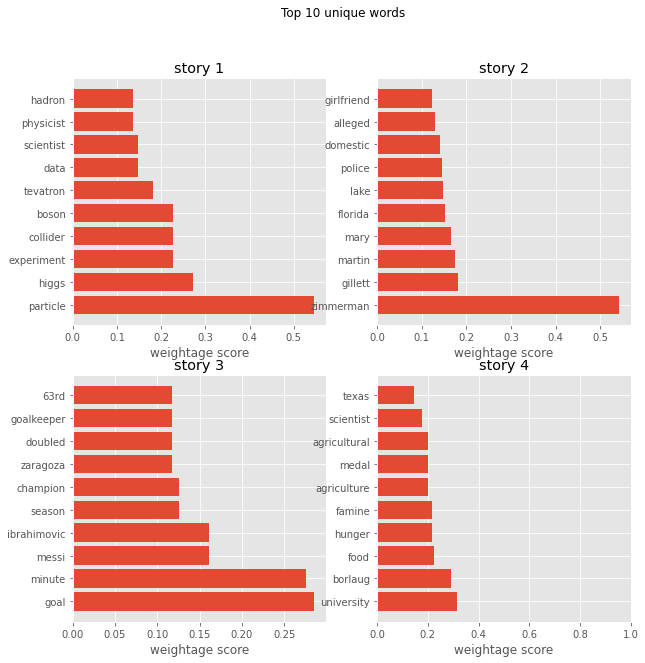

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig, ax = plt.subplots(2, 2,figsize=(10,10))

names1, values1 = for_plot(story1)
ax[0,0].barh(range(len(names1)), values1, tick_label=names1)
ax[0,0].set_title("story 1")
plt.xlim([0, 1])

names2, values2 = for_plot(story2)
ax[0,1].barh(range(len(names2)), values2, tick_label=names2)
ax[0,1].set_title("story 2")
plt.xlim([0, 1])

names3, values3 = for_plot(story3)
ax[1,0].barh(range(len(names3)), values3, tick_label=names3)
ax[1,0].set_title("story 3")
plt.xlim([0, 1])

names4, values4 = for_plot(story4)
ax[1,1].barh(range(len(names4)), values4, tick_label=names4)
ax[1,1].set_title("story 4")
plt.xlim([0, 1])

for a in ax.flat:
    a.set(xlabel='weightage score')
fig.suptitle('Top 10 unique words')

plt.show()

In [95]:
# ## cosine similarity between documents
# from sklearn.metrics.pairwise import cosine_similarity

# csim = cosine_similarity(tfIdfmat, tfIdfmat)
# pd.DataFrame(csim)